In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 

from sklearn.preprocessing import OneHotEncoder

In [2]:
class MLP:
    
  def __init__(self):
    self.w = None
    self.b = None
    
  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b
  
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)
  
  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")
    
  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False):
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0
      
    if display_loss:
      loss = {}
    
    for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dw = 0
      db = 0
      for x, y in zip(X, Y):
        if loss_fn == "mse":
          dw += self.grad_w_mse(x, y)
          db += self.grad_b_mse(x, y) 
        elif loss_fn == "ce":
          dw += self.grad_w_ce(x, y)
          db += self.grad_b_ce(x, y)
          
      m = X.shape[1]  
      self.w -= learning_rate * dw/m
      self.b -= learning_rate * db/m
      
      if display_loss:
        Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
          loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
          loss[i] = log_loss(Y, Y_pred)
    
    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()
      
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

C:\Users\GOD WORLD\AppData\Local\Temp\ipykernel_17164\1894556098.py:49: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):


  0%|          | 0/1000 [00:00<?, ?epoch/s]

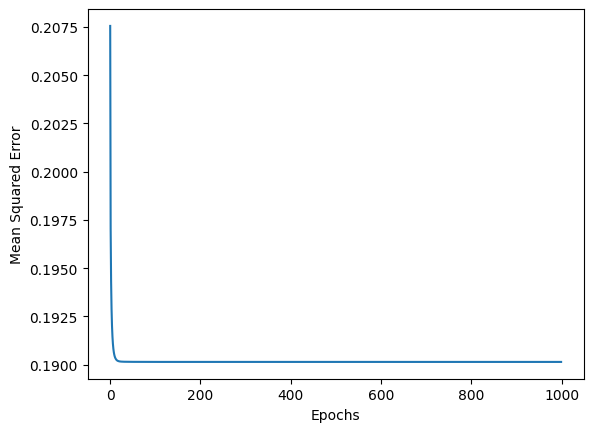

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the Titanic dataset
titanic_df = pd.read_csv(r'dataset/train.csv')

# Preprocess the dataset
titanic_df = titanic_df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Survived']].dropna()
X = titanic_df.drop('Survived', axis=1).values
y = titanic_df['Survived'].values.reshape(-1, 1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create an instance of the SigmoidNeuron class
sn = SigmoidNeuron()

# Train the model
sn.fit(X_train, y_train, epochs=1000, learning_rate=0.1, initialise=True, loss_fn="mse", display_loss=True)

# Make predictions
Y_pred = sn.predict(X_test)


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

class MLP():
    
    def __init__(self,X,Y,X_val,Y_val,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(2)[Y.astype(np.int).reshape(-1)])  # Assuming binary classification
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = np.squeeze(np.eye(2)[Y_val.astype(np.int).reshape(-1)])  # Assuming binary classification
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]
        
    def __sigmoid(self,x):
        return 1./(1.+np.exp(-x))
    
    def __softmax(self,x):
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __loss(self,y_pred,y):
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self,y_pred,y):  
        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self,h):
        return h*(1-h)
    
    def __to_categorical(self,x):  
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights)
    
    def __init_layers(self,batch_size):
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__sigmoid(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        delta_t = (self.__out - batch_y)*self.__sigmoid_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__sigmoid_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self,X):
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self,X,Y):
        prediction = self.predict(X)
        return self.__accuracy(prediction,Y)
        
    def train(self,batch_size=8,epochs=25,lr=1.0):
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")


# Load Titanic dataset
titanic_data = pd.read_csv('dataset/train.csv')

# Preprocess your data
titanic_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
titanic_data = pd.get_dummies(titanic_data, columns=['Sex'], drop_first=True)
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)
titanic_data['Fare'].fillna(titanic_data['Fare'].median(), inplace=True)

# Split data into features and target
X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Instantiate the MLP model
mlp_model = MLP(X_train, y_train, X_val, y_val, L=1, N_l=128)

# Train the model
mlp_model.train(batch_size=8, epochs=25, lr=1.0)

# Evaluate the model
accuracy = mlp_model.evaluate(X_val, y_val)
print("Validation Accuracy:", accuracy)


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv("dataset/adult.csv")

# Data Preprocessing
# Assuming '?' represents missing values, replace them with NaN
data.replace('?', np.nan, inplace=True)

# Drop rows with missing values
data.dropna(inplace=True)

# Encode categorical variables
label_encoder = LabelEncoder()
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = label_encoder.fit_transform(data[column])

# Split the data into features (X) and target variable (Y)
X = data.drop(columns=['income'])
Y = np.array(data['income'])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Feature Scaling (optional but recommended for better performance)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate the SigmoidNeuron class
sn = SigmoidNeuron()

# Train the model
sn.fit(X_train_scaled, y_train, epochs=1000, learning_rate=0.1, initialise=True, loss_fn="mse", display_loss=True)

# Make predictions
predictions = sn.predict(X_test_scaled)

# Convert predictions to binary (>= 0.5 is considered as 1, < 0.5 is considered as 0)
binary_predictions = (predictions >= 0.5).astype(int)

# Print the predictions
print("Predictions:", binary_predictions)


NameError: name 'SigmoidNeuron' is not defined

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

class MLP():
    
    def __init__(self,X,Y,X_val,Y_val,L=1,N_l=128):
        self.X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.Y = np.squeeze(np.eye(2)[Y.astype(int).reshape(-1)])  # Updated here
        self.X_val = np.concatenate((X_val,np.ones((X_val.shape[0],1))),axis=1)
        self.Y_val = np.squeeze(np.eye(2)[Y_val.astype(int).reshape(-1)])  # Updated here
        self.L = L
        self.N_l = N_l
        self.n_samples = self.X.shape[0]
        self.layer_sizes = np.array([self.X.shape[1]]+[N_l]*L+[self.Y.shape[1]]) 
        self.__init_weights()
        self.train_loss = list()
        self.train_acc = list()
        self.val_loss = list()
        self.val_acc = list()
        self.train_time = list()
        self.tot_time = list()
        self.metrics = [self.train_loss,self.train_acc,self.val_loss,self.val_acc,self.train_time,self.tot_time]
        
    def __sigmoid(self,x):
        return 1./(1.+np.exp(-x))
    
    def __softmax(self,x):
        exponent = np.exp(x)
        return exponent/exponent.sum(axis=1,keepdims=True)
    
    def __loss(self,y_pred,y):
        return ((-np.log(y_pred))*y).sum(axis=1).mean()
    
    def __accuracy(self,y_pred,y):  
        return np.all(y_pred==y,axis=1).mean()
    
    def __sigmoid_prime(self,h):
        return h*(1-h)
    
    def __to_categorical(self,x):  
        categorical = np.zeros((x.shape[0],self.Y.shape[1]))
        categorical[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
        return categorical
    
    def __init_weights(self):
        self.weights = list()
        for i in range(self.layer_sizes.shape[0]-1):
            self.weights.append(np.random.uniform(-1,1,size=[self.layer_sizes[i],self.layer_sizes[i+1]]))
        self.weights = np.asarray(self.weights)
    
    def __init_layers(self,batch_size):
        self.__h = [np.empty((batch_size,layer)) for layer in self.layer_sizes]
    
    def __feed_forward(self,batch):
        h_l = batch
        self.__h[0] = h_l
        for i,weights in enumerate(self.weights):
            h_l = self.__sigmoid(h_l.dot(weights))
            self.__h[i+1]=h_l
        self.__out = self.__softmax(self.__h[-1])
    
    def __back_prop(self,batch_y):
        delta_t = (self.__out - batch_y)*self.__sigmoid_prime(self.__h[-1])
        for i in range(1,len(self.weights)+1):
            self.weights[-i]-=self.lr*(self.__h[-i-1].T.dot(delta_t))/self.batch_size
            delta_t = self.__sigmoid_prime(self.__h[-i-1])*(delta_t.dot(self.weights[-i].T))
            
    def predict(self,X):
        X = np.concatenate((X,np.ones((X.shape[0],1))),axis=1)
        self.__init_layers(X.shape[0])
        self.__feed_forward(X)
        return self.__to_categorical(self.__out)
    
    def evaluate(self,X,Y):
        prediction = self.predict(X)
        return self.__accuracy(prediction,Y)
        
    def train(self,batch_size=8,epochs=25,lr=1.0):
        self.lr = lr
        self.batch_size=batch_size
        for epoch in range(epochs):
            start = time.time()
            
            self.__init_layers(self.batch_size)
            shuffle = np.random.permutation(self.n_samples)
            train_loss = 0
            train_acc = 0
            X_batches = np.array_split(self.X[shuffle],self.n_samples/self.batch_size)
            Y_batches = np.array_split(self.Y[shuffle],self.n_samples/self.batch_size)
            for batch_x,batch_y in zip(X_batches,Y_batches):
                self.__feed_forward(batch_x)  
                train_loss += self.__loss(self.__out,batch_y)
                train_acc += self.__accuracy(self.__to_categorical(self.__out),batch_y)
                self.__back_prop(batch_y)
                
            train_loss = (train_loss/len(X_batches))
            train_acc = (train_acc/len(X_batches))
            self.train_loss.append(train_loss)
            self.train_acc.append(train_acc)
            
            train_time = round(time.time()-start,3)
            self.train_time.append(train_time)
            
            self.__init_layers(self.X_val.shape[0])
            self.__feed_forward(self.X_val)
            val_loss = self.__loss(self.__out,self.Y_val)
            val_acc = self.__accuracy(self.__to_categorical(self.__out),self.Y_val)
            self.val_loss.append(val_loss)
            self.val_acc.append(val_acc)
            
            tot_time = round(time.time()-start,3)
            self.tot_time.append(tot_time)
            
            print(f"Epoch {epoch+1}: loss = {train_loss.round(3)} | acc = {train_acc.round(3)} | val_loss = {val_loss.round(3)} | val_acc = {val_acc.round(3)} | train_time = {train_time} | tot_time = {tot_time}")


# Load Titanic dataset
titanic_data = pd.read_csv('dataset/train.csv')

# Preprocess your data
titanic_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
titanic_data = pd.get_dummies(titanic_data, columns=['Sex'], drop_first=True)
titanic_data['Age'].fillna(titanic_data['Age'].median(), inplace=True)
titanic_data['Fare'].fillna(titanic_data['Fare'].median(), inplace=True)

# Split data into features and target
X = titanic_data.drop('Survived', axis=1)
y = titanic_data['Survived']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Instantiate the MLP model
mlp_model = MLP(X_train, y_train, X_val, y_val, L=1, N_l=128)

# Train the model
mlp_model.train(batch_size=8, epochs=25, lr=1.0)

# Evaluate the model
accuracy = mlp_model.evaluate(X_val, y_val)
print("Validation Accuracy:", accuracy)


AttributeError: 'Series' object has no attribute 'reshape'

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Step 1: Read the dataset
data = pd.read_csv("dataset\indian_liver_patient.csv")  # Replace "your_dataset.csv" with the path to your dataset

# Step 2: Preprocess the data
# Encode categorical variable "Gender" using one-hot encoding
data = pd.get_dummies(data, columns=["Gender"])

# Split the data into features (X) and labels (y)
X = data.drop(columns=["Dataset"])  # Features
y = data["Dataset"]  # Labels

# Normalize numerical features if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalize numerical features

# Step 3: Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 4: Instantiate the MLP model
mlp_model = MLP(X_train, y_train, X_val, y_val, L=1, N_l=128)

# Train the model
mlp_model.train(batch_size=8, epochs=25, lr=1.0)

# Evaluate the model
accuracy = mlp_model.evaluate(X_val, y_val)
print("Validation Accuracy:", accuracy)


AttributeError: 'Series' object has no attribute 'reshape'